##### Copyright 2019 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [2]:
#@title MIT License
#
# Copyright (c) 2017 François Chollet                                                                                                                    # IGNORE_COPYRIGHT: cleared by OSS licensing
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

# Transfer learning and fine-tuning

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/images/transfer_learning"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/images/transfer_learning.ipynb?force_kitty_mode=1&force_corgi_mode=1"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/images/transfer_learning.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/images/transfer_learning.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

In this tutorial, you will learn how to classify images of cats and dogs by using transfer learning from a pre-trained network.

A pre-trained model is a saved network that was previously trained on a large dataset, typically on a large-scale image-classification task. You either use the pretrained model as is or use transfer learning to customize this model to a given task.

The intuition behind transfer learning for image classification is that if a model is trained on a large and general enough dataset, this model will effectively serve as a generic model of the visual world. You can then take advantage of these learned feature maps without having to start from scratch by training a large model on a large dataset.

In this notebook, you will try two ways to customize a pretrained model:

1. Feature Extraction: Use the representations learned by a previous network to extract meaningful features from new samples. You simply add a new classifier, which will be trained from scratch, on top of the pretrained model so that you can repurpose the feature maps learned previously for the dataset.

 You do not need to (re)train the entire model. The base convolutional network already contains features that are generically useful for classifying pictures. However, the final, classification part of the pretrained model is specific to the original classification task, and subsequently specific to the set of classes on which the model was trained.

1. Fine-Tuning: Unfreeze a few of the top layers of a frozen model base and jointly train both the newly-added classifier layers and the last layers of the base model. This allows us to "fine-tune" the higher-order feature representations in the base model in order to make them more relevant for the specific task.

You will follow the general machine learning workflow.

1. Examine and understand the data
1. Build an input pipeline, in this case using Keras ImageDataGenerator
1. Compose the model
   * Load in the pretrained base model (and pretrained weights)
   * Stack the classification layers on top
1. Train the model
1. Evaluate model


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

## Data preprocessing

### Data download

In this tutorial, you will use a dataset containing several thousand images of cats and dogs. Download and extract a zip file containing the images, then create a `tf.data.Dataset` for training and validation using the `tf.keras.utils.image_dataset_from_directory` utility. You can learn more about loading images in this [tutorial](https://www.tensorflow.org/tutorials/load_data/images).

In [4]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

68606236/68606236 ━━━━━━━━━━━━━━━━━━━━ 12s 0us/step
Found 2000 files belonging to 2 classes.


25174016/68606236 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

39854080/68606236 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

52117504/68606236 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

65585152/68606236 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

68606236/68606236 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Found 2000 files belonging to 2 classes.


I0000 00:00:1721365787.906248   77561 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


I0000 00:00:1721365787.910125   77561 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1721365787.913670   77561 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1721365787.917204   77561 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1721365787.928345   77561 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

In [5]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 1000 files belonging to 2 classes.


Show the first nine images and labels from the training set:

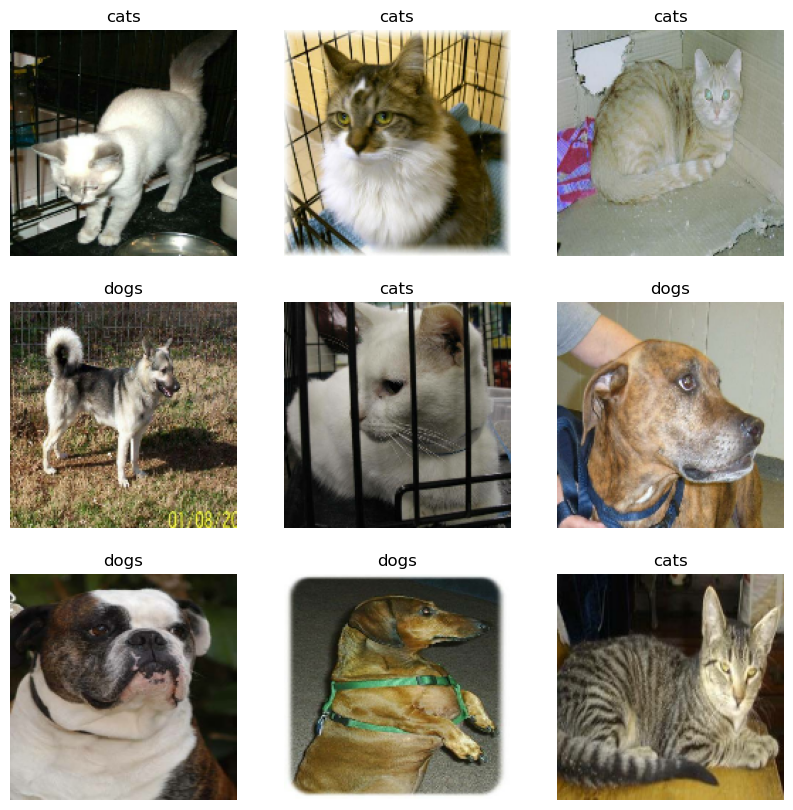

In [6]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

As the original dataset doesn't contain a test set, you will create one. To do so, determine how many batches of data are available in the validation set using `tf.data.experimental.cardinality`, then move 20% of them to a test set.

In [7]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [8]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 26
Number of test batches: 6


### Configure the dataset for performance

Use buffered prefetching to load images from disk without having I/O become blocking. To learn more about this method see the [data performance](https://www.tensorflow.org/guide/data_performance) guide.

In [9]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

### Use data augmentation

When you don't have a large image dataset, it's a good practice to artificially introduce sample diversity by applying random, yet realistic, transformations to the training images, such as rotation and horizontal flipping. This helps expose the model to different aspects of the training data and reduce [overfitting](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit). You can learn more about data augmentation in this [tutorial](https://www.tensorflow.org/tutorials/images/data_augmentation).

In [10]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

Note: These layers are active only during training, when you call `Model.fit`. They are inactive when the model is used in inference mode in `Model.evaluate`, `Model.predict`, or `Model.call`.

Let's repeatedly apply these layers to the same image and see the result.

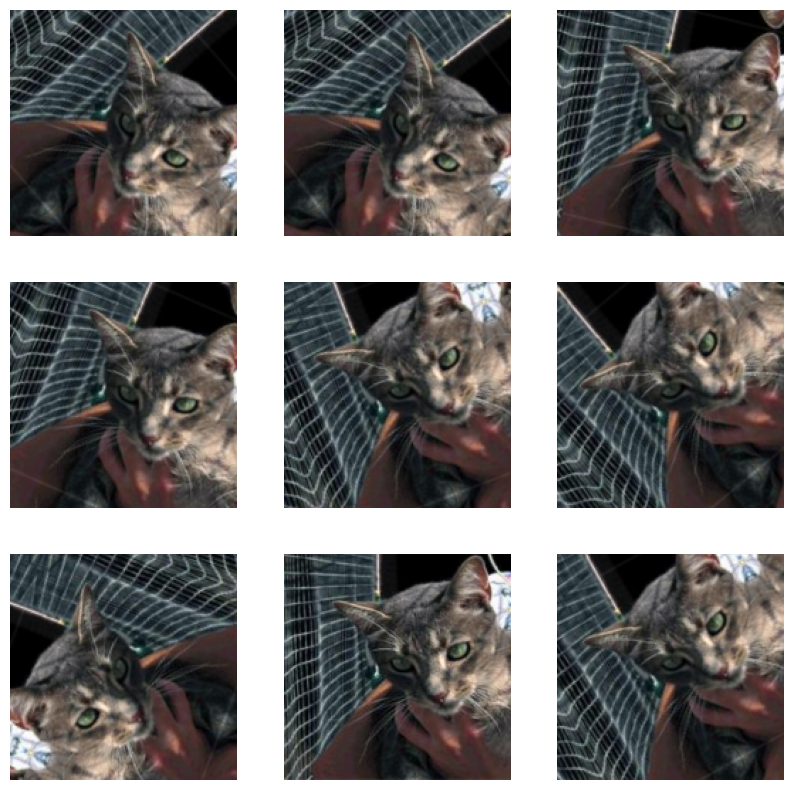

In [11]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

### Rescale pixel values

In a moment, you will download `tf.keras.applications.MobileNetV2` for use as your base model. This model expects pixel values in `[-1, 1]`, but at this point, the pixel values in your images are in `[0, 255]`. To rescale them, use the preprocessing method included with the model.

In [12]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

Note: Alternatively, you could rescale pixel values from `[0, 255]` to `[-1, 1]` using `tf.keras.layers.Rescaling`.

In [13]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

Note: If using other `tf.keras.applications`, be sure to check the API doc to determine if they expect pixels in `[-1, 1]` or `[0, 1]`, or use the included `preprocess_input` function.

## Create the base model from the pre-trained convnets
You will create the base model from the **MobileNet V2** model developed at Google. This is pre-trained on the ImageNet dataset, a large dataset consisting of 1.4M images and 1000 classes. ImageNet is a research training dataset with a wide variety of categories like `jackfruit` and `syringe`. This base of knowledge will help us classify cats and dogs from our specific dataset.

First, you need to pick which layer of MobileNet V2 you will use for feature extraction. The very last classification layer (on "top", as most diagrams of machine learning models go from bottom to top) is not very useful. Instead, you will follow the common practice to depend on the very last layer before the flatten operation. This layer is called the "bottleneck layer". The bottleneck layer features retain more generality as compared to the final/top layer.

First, instantiate a MobileNet V2 model pre-loaded with weights trained on ImageNet. By specifying the **include_top=False** argument, you load a network that doesn't include the classification layers at the top, which is ideal for feature extraction.

In [14]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


This feature extractor converts each `160x160x3` image into a `5x5x1280` block of features. Let's see what it does to an example batch of images:

In [15]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


## Feature extraction
In this step, you will freeze the convolutional base created from the previous step and to use as a feature extractor. Additionally, you add a classifier on top of it and train the top-level classifier.

### Freeze the convolutional base

It is important to freeze the convolutional base before you compile and train the model. Freezing (by setting layer.trainable = False) prevents the weights in a given layer from being updated during training. MobileNet V2 has many layers, so setting the entire model's `trainable` flag to False will freeze all of them.

In [16]:
base_model.trainable = False

### Important note about BatchNormalization layers

Many models contain `tf.keras.layers.BatchNormalization` layers. This layer is a special case and precautions should be taken in the context of fine-tuning, as shown later in this tutorial.

When you set `layer.trainable = False`, the `BatchNormalization` layer will run in inference mode, and will not update its mean and variance statistics.

When you unfreeze a model that contains BatchNormalization layers in order to do fine-tuning, you should keep the BatchNormalization layers in inference mode by passing `training = False` when calling the base model. Otherwise, the updates applied to the non-trainable weights will destroy what the model has learned.

For more details, see the [Transfer learning guide](https://www.tensorflow.org/guide/keras/transfer_learning).

In [17]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_160"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 80, 80,    │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 80, 80,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 80, 80,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 80, 80,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 80, 80,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 80, 80,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 81, 81,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 40, 40,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 40, 40,    │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

### Add a classification head

To generate predictions from the block of features, average over the spatial `5x5` spatial locations, using a `tf.keras.layers.GlobalAveragePooling2D` layer to convert the features to  a single 1280-element vector per image.

In [18]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


Apply a `tf.keras.layers.Dense` layer to convert these features into a single prediction per image. You don't need an activation function here because this prediction will be treated as a `logit`, or a raw prediction value. Positive numbers predict class 1, negative numbers predict class 0.

In [19]:
prediction_layer = tf.keras.layers.Dense(1, activation='sigmoid')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


Build a model by chaining together the data augmentation, rescaling, `base_model` and feature extractor layers using the [Keras Functional API](https://www.tensorflow.org/guide/keras/functional). As previously mentioned, use `training=False` as our model contains a `BatchNormalization` layer.

In [20]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [21]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

The 8+ million parameters in MobileNet are frozen, but there are 1.2 thousand _trainable_ parameters in the Dense layer. These are divided between two `tf.Variable` objects, the weights and biases.

In [22]:
len(model.trainable_variables)

2

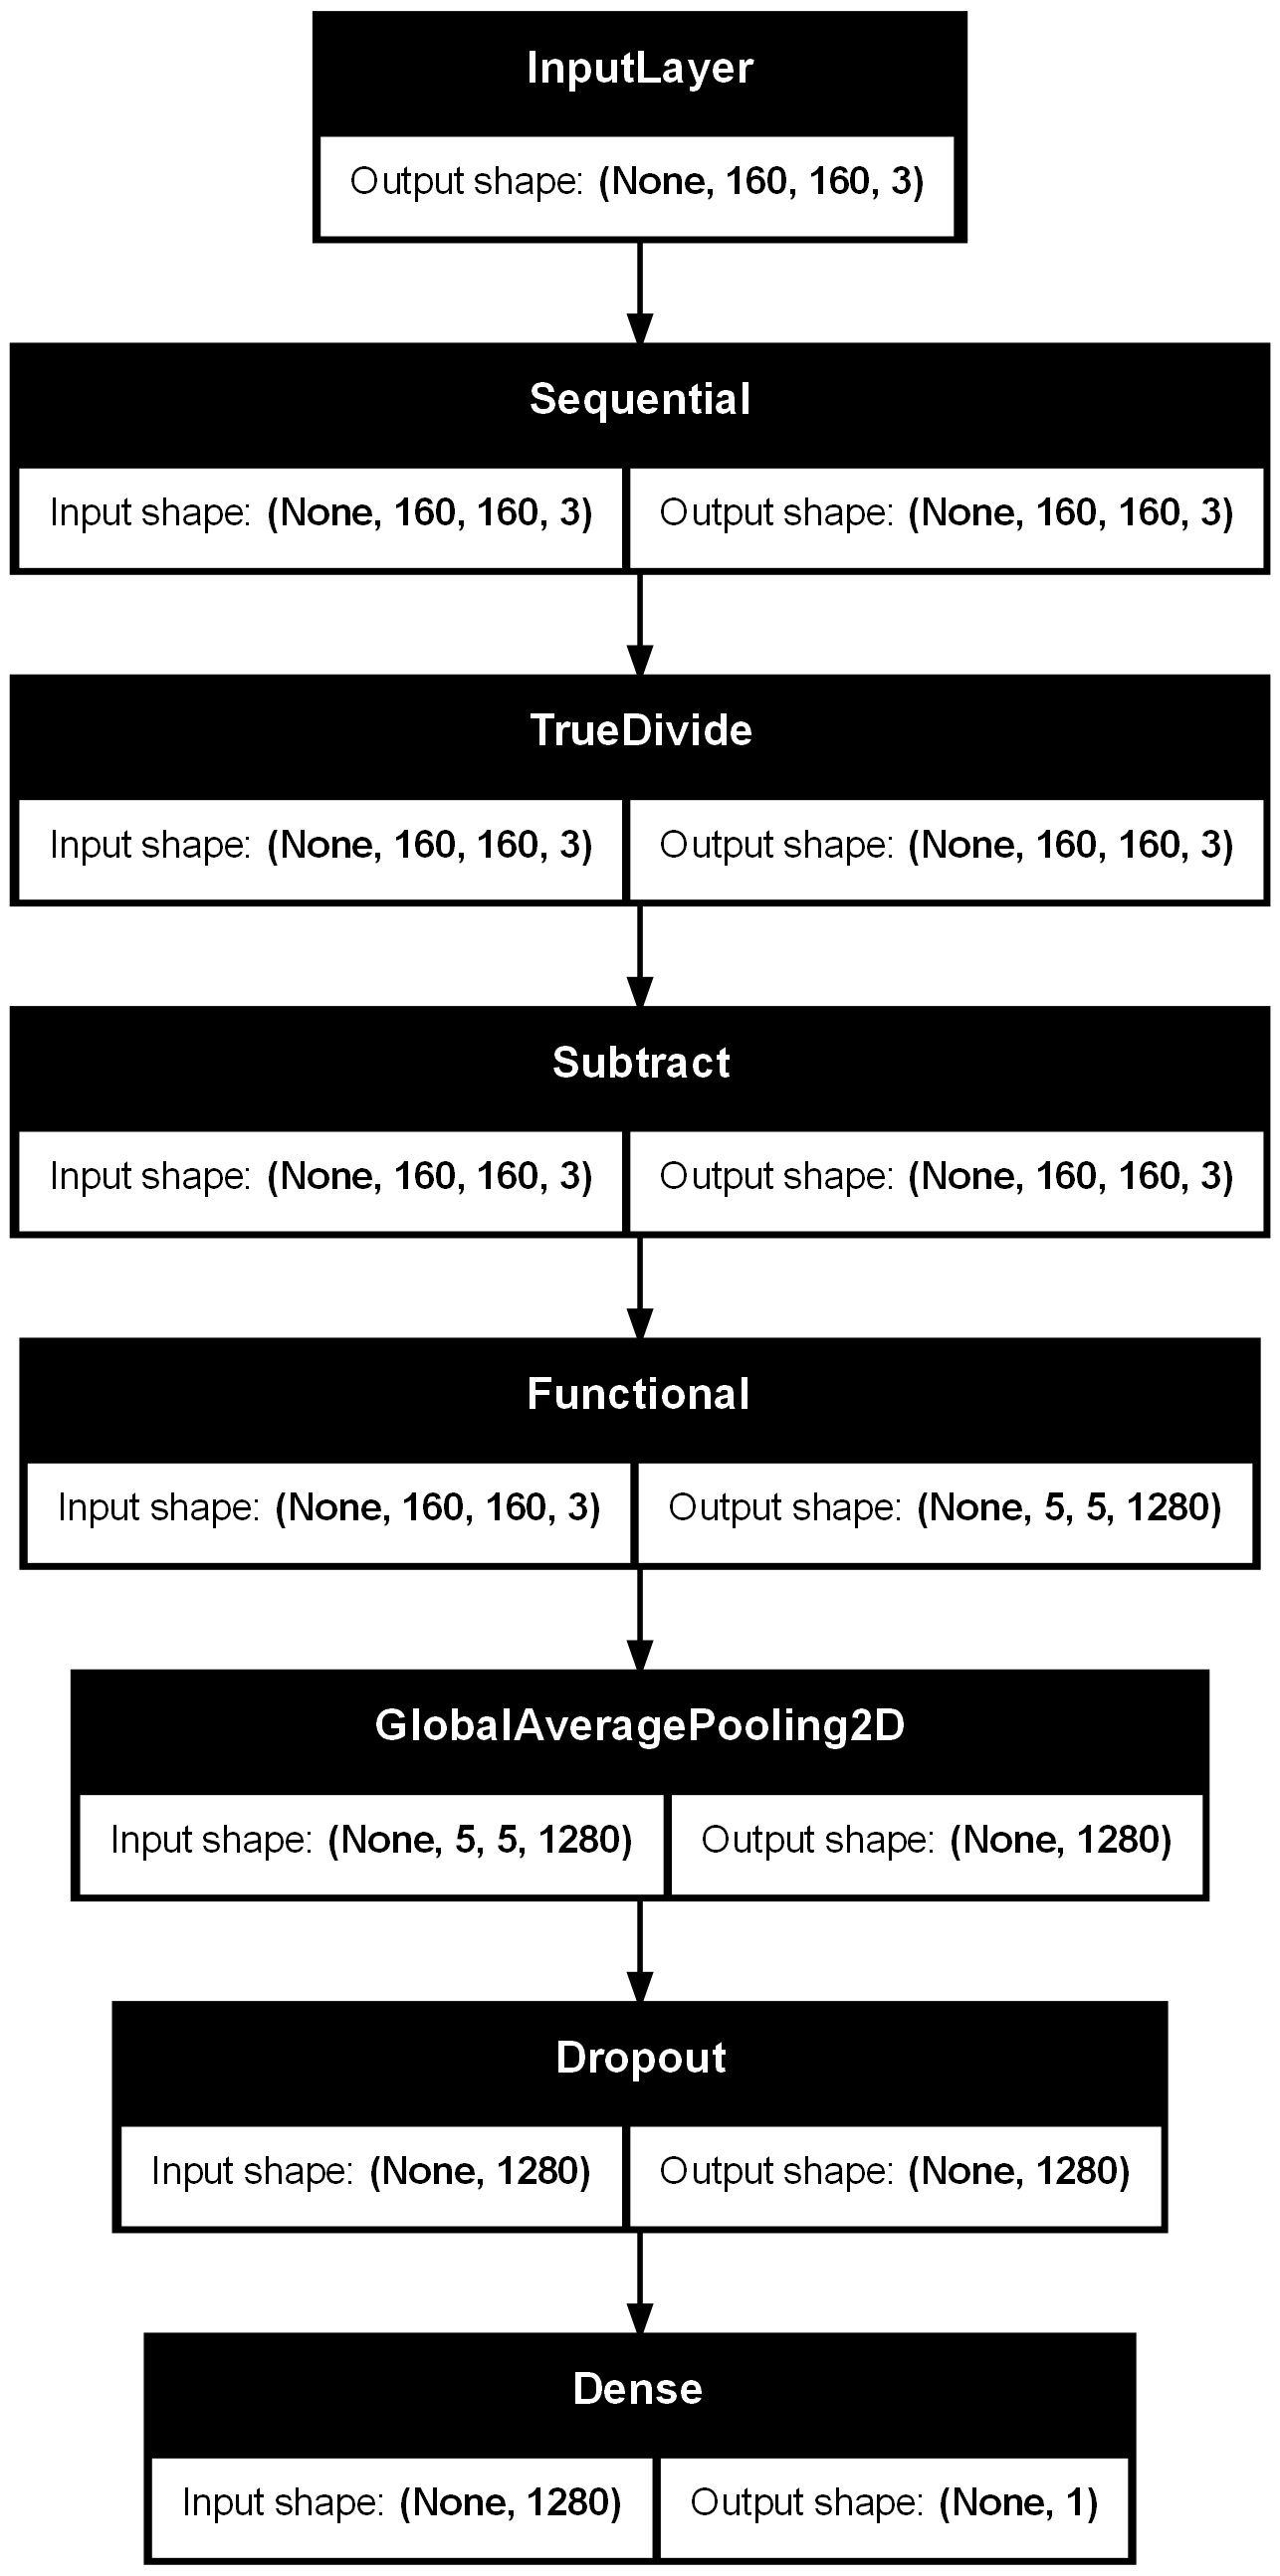

In [23]:
tf.keras.utils.plot_model(model, show_shapes=True)

### Compile the model

Compile the model before training it. Since there are two classes and a sigmoid oputput, use the `BinaryAccuracy`.

In [24]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5, name='accuracy')])

### Train the model

After training for 10 epochs, you should see ~96% accuracy on the validation set.


In [25]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

26/26 ━━━━━━━━━━━━━━━━━━━━ 10s 222ms/step - accuracy: 0.6073 - loss: 0.6650


13/26 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.2610 - loss: 1.0280

15/26 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.2633 - loss: 1.0254

17/26 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.2640 - loss: 1.0235

19/26 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.2645 - loss: 1.0227

21/26 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.2649 - loss: 1.0219

23/26 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.2649 - loss: 1.0211

25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.2656 - loss: 1.0196

W0000 00:00:1721365797.973659   77761 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1721365797.974554   77761 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1721365797.975377   77761 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1721365797.976217   77761 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1721365797.977059   77761 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1721365797.977861   77761 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1721365797.978652   77761 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1721365797.979403   77761 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1721365797.980169   77761 gp

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.2659 - loss: 1.0188

26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.2662 - loss: 1.0181


W0000 00:00:1721365798.175219   77761 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1721365798.175926   77761 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1721365798.176615   77761 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1721365798.177351   77761 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1721365798.178140   77761 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1721365798.184380   77761 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1721365798.185082   77761 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1721365798.185740   77761 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1721365798.186410   77761 gp

In [26]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.66
initial accuracy: 0.62


In [27]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 33s 350ms/step - accuracy: 0.5879 - loss: 0.7095 - val_accuracy: 0.8342 - val_loss: 0.4493
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 23s 358ms/step - accuracy: 0.7510 - loss: 0.5246 - val_accuracy: 0.9022 - val_loss: 0.3357
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 23s 357ms/step - accuracy: 0.8289 - loss: 0.3995 - val_accuracy: 0.9369 - val_loss: 0.2636
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 350ms/step - accuracy: 0.8397 - loss: 0.3616 - val_accuracy: 0.9567 - val_loss: 0.2171
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 342ms/step - accuracy: 0.8703 - loss: 0.3188 - val_accuracy: 0.9604 - val_loss: 0.1841
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 355ms/step - accuracy: 0.8890 - loss: 0.2800 - val_accuracy: 0.9678 - val_loss: 0.1677
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 25s 397ms/step - accuracy: 0.8997 - loss: 0.2518 - val_accuracy: 0.9703 - val_loss: 0.1495
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 23s 357ms/step - accuracy: 0.9093 - loss: 0.2510 - val_accu

19/63 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.4118 - loss: 0.9315

21/63 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.4126 - loss: 0.9292

23/63 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.4135 - loss: 0.9272

25/63 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.4149 - loss: 0.9248

27/63 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.4162 - loss: 0.9224

29/63 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.4174 - loss: 0.9201

31/63 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.4190 - loss: 0.9173

33/63 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.4204 - loss: 0.9148

35/63 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.4217 - loss: 0.9123

37/63 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.4234 - loss: 0.9097

39/63 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.4250 - loss: 0.9071

41/63 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.4263 - loss: 0.9046

43/63 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.4278 - loss: 0.9020

45/63 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.4292 - loss: 0.8995

47/63 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.4306 - loss: 0.8971

49/63 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.4321 - loss: 0.8947

51/63 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.4336 - loss: 0.8924

53/63 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.4349 - loss: 0.8901

55/63 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.4363 - loss: 0.8879

57/63 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.4377 - loss: 0.8858

59/63 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.4391 - loss: 0.8835

61/63 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.4405 - loss: 0.8813

W0000 00:00:1721365805.142475   77764 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1721365805.143426   77764 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1721365805.144325   77764 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1721365805.145198   77764 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1721365805.146071   77764 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1721365805.146973   77764 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1721365805.147954   77764 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1721365805.148840   77764 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1721365805.149732   77764 gp

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.4419 - loss: 0.8791

W0000 00:00:1721365805.344426   77764 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1721365805.345099   77764 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1721365805.345766   77764 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1721365805.346437   77764 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1721365805.347104   77764 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1721365805.347778   77764 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1721365805.348452   77764 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1721365805.349157   77764 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1721365805.349829   77764 gp

63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 49ms/step - accuracy: 0.4426 - loss: 0.8780 - val_accuracy: 0.6027 - val_loss: 0.6711


Epoch 2/10


 1/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.6875 - loss: 0.6686

 3/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.6719 - loss: 0.6605

 5/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.6894 - loss: 0.6317

 7/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.6897 - loss: 0.6233

 9/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.6849 - loss: 0.6232

11/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.6784 - loss: 0.6269

13/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.6725 - loss: 0.6298

15/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.6670 - loss: 0.6326

17/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.6615 - loss: 0.6352

19/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.6579 - loss: 0.6373

21/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.6555 - loss: 0.6393

23/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.6546 - loss: 0.6400

25/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.6542 - loss: 0.6400

27/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.6536 - loss: 0.6401

29/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.6534 - loss: 0.6399

31/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.6535 - loss: 0.6395

33/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.6536 - loss: 0.6393

35/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.6539 - loss: 0.6390

37/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.6543 - loss: 0.6382

39/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.6551 - loss: 0.6372

41/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.6558 - loss: 0.6362

43/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.6566 - loss: 0.6351

45/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.6575 - loss: 0.6341

47/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.6584 - loss: 0.6331

49/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.6594 - loss: 0.6320

51/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.6605 - loss: 0.6309

53/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.6614 - loss: 0.6298

55/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.6625 - loss: 0.6285

57/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.6636 - loss: 0.6272

59/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.6648 - loss: 0.6259

61/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.6660 - loss: 0.6246

63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.6678 - loss: 0.6226 - val_accuracy: 0.8280 - val_loss: 0.4723


Epoch 3/10


 1/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.7500 - loss: 0.4676

 3/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.7413 - loss: 0.5074

 5/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.7598 - loss: 0.5019

 7/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.7618 - loss: 0.5046

 9/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.7600 - loss: 0.5084

11/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.7574 - loss: 0.5107

13/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.7568 - loss: 0.5110

15/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.7571 - loss: 0.5110

17/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.7582 - loss: 0.5105

19/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.7607 - loss: 0.5088

21/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.7623 - loss: 0.5076

23/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.7634 - loss: 0.5067

25/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.7642 - loss: 0.5055

27/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.7649 - loss: 0.5044

29/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.7660 - loss: 0.5030

31/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7668 - loss: 0.5020

33/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7678 - loss: 0.5008

35/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7689 - loss: 0.4997

37/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7697 - loss: 0.4987

39/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7705 - loss: 0.4979

41/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7713 - loss: 0.4971

43/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7722 - loss: 0.4963

45/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7731 - loss: 0.4954

47/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7740 - loss: 0.4944

49/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7750 - loss: 0.4934

51/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7758 - loss: 0.4924

53/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7766 - loss: 0.4915

55/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7773 - loss: 0.4907

57/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7780 - loss: 0.4898

59/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7787 - loss: 0.4889

61/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7795 - loss: 0.4879

63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.7808 - loss: 0.4865 - val_accuracy: 0.9196 - val_loss: 0.3519


Epoch 4/10


 1/63 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.8125 - loss: 0.4433

 3/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.8142 - loss: 0.4698

 5/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8254 - loss: 0.4628

 7/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8315 - loss: 0.4557

 9/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8330 - loss: 0.4540

11/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8347 - loss: 0.4506

13/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8338 - loss: 0.4494

15/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8336 - loss: 0.4478

17/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8346 - loss: 0.4456

19/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8351 - loss: 0.4438

21/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8357 - loss: 0.4416

23/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8363 - loss: 0.4395

25/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8371 - loss: 0.4372

27/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8377 - loss: 0.4351

29/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8383 - loss: 0.4331

31/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8389 - loss: 0.4313

33/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8393 - loss: 0.4297

35/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8395 - loss: 0.4284

37/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8398 - loss: 0.4270

39/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8403 - loss: 0.4256

41/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8407 - loss: 0.4242

43/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8409 - loss: 0.4231

45/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8411 - loss: 0.4221

47/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8413 - loss: 0.4211

49/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8416 - loss: 0.4201

51/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8418 - loss: 0.4192

53/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8420 - loss: 0.4182

55/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8423 - loss: 0.4172

57/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8427 - loss: 0.4162

59/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8431 - loss: 0.4151

61/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8435 - loss: 0.4141

63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.8440 - loss: 0.4126 - val_accuracy: 0.9406 - val_loss: 0.2800


Epoch 5/10


 1/63 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.9375 - loss: 0.2847

 3/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9219 - loss: 0.2977

 5/63 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.9056 - loss: 0.3107

 7/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8977 - loss: 0.3176

 9/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8919 - loss: 0.3212

11/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8872 - loss: 0.3245

13/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8832 - loss: 0.3274

15/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8794 - loss: 0.3318

17/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8759 - loss: 0.3364

19/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8736 - loss: 0.3395

21/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8714 - loss: 0.3418

23/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8699 - loss: 0.3431

25/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8688 - loss: 0.3444

27/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8677 - loss: 0.3454

29/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8669 - loss: 0.3461

31/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8664 - loss: 0.3466

33/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8659 - loss: 0.3472

35/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8655 - loss: 0.3476

37/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8650 - loss: 0.3481

39/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8646 - loss: 0.3484

41/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8643 - loss: 0.3485

43/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8640 - loss: 0.3486

45/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8637 - loss: 0.3487

47/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8634 - loss: 0.3488

49/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8632 - loss: 0.3488

51/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8630 - loss: 0.3488

53/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8628 - loss: 0.3487

55/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8627 - loss: 0.3485

57/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8627 - loss: 0.3484

59/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8628 - loss: 0.3481

61/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8629 - loss: 0.3478

63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.8631 - loss: 0.3474 - val_accuracy: 0.9480 - val_loss: 0.2357


Epoch 6/10


 1/63 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.9062 - loss: 0.2730

 3/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9097 - loss: 0.2725

 5/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9143 - loss: 0.2712

 7/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9072 - loss: 0.2784

 9/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9029 - loss: 0.2840

11/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9018 - loss: 0.2849

13/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9012 - loss: 0.2850

15/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9011 - loss: 0.2844

17/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9013 - loss: 0.2841

19/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9018 - loss: 0.2841

21/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9019 - loss: 0.2843

23/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9020 - loss: 0.2849

25/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9021 - loss: 0.2854

27/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9026 - loss: 0.2856

29/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9030 - loss: 0.2860

31/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9034 - loss: 0.2862

33/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9036 - loss: 0.2866

35/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9037 - loss: 0.2869

37/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9037 - loss: 0.2873

39/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9034 - loss: 0.2877

41/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9032 - loss: 0.2880

43/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9031 - loss: 0.2884

45/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9029 - loss: 0.2887

47/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9028 - loss: 0.2889

49/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9027 - loss: 0.2890

51/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9025 - loss: 0.2893

53/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9023 - loss: 0.2895

55/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9022 - loss: 0.2897

57/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9020 - loss: 0.2899

59/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9019 - loss: 0.2900

61/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9018 - loss: 0.2900

63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.9017 - loss: 0.2901 - val_accuracy: 0.9592 - val_loss: 0.1975


Epoch 7/10


 1/63 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.9375 - loss: 0.2464

 3/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9462 - loss: 0.2346

 5/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9471 - loss: 0.2333

 7/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9395 - loss: 0.2401

 9/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9341 - loss: 0.2470

11/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9323 - loss: 0.2495

13/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9313 - loss: 0.2513

15/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9301 - loss: 0.2535

17/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9289 - loss: 0.2549

19/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9281 - loss: 0.2554

21/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9270 - loss: 0.2561

23/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9261 - loss: 0.2569

25/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9258 - loss: 0.2570

27/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9253 - loss: 0.2572

29/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9247 - loss: 0.2577

31/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9239 - loss: 0.2582

33/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9230 - loss: 0.2589

35/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9222 - loss: 0.2594

37/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9214 - loss: 0.2600

39/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9206 - loss: 0.2608

41/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9199 - loss: 0.2615

43/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9193 - loss: 0.2621

45/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9187 - loss: 0.2626

47/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9183 - loss: 0.2631

49/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9179 - loss: 0.2635

51/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9174 - loss: 0.2640

53/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9170 - loss: 0.2645

55/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9166 - loss: 0.2648

57/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9162 - loss: 0.2651

59/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9158 - loss: 0.2653

61/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9155 - loss: 0.2655

63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.9151 - loss: 0.2656 - val_accuracy: 0.9604 - val_loss: 0.1786


Epoch 8/10


 1/63 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.9062 - loss: 0.2728

 3/63 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.9271 - loss: 0.2373

 5/63 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.9241 - loss: 0.2320

 7/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9217 - loss: 0.2308

 9/63 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.9179 - loss: 0.2325

11/63 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.9144 - loss: 0.2358

13/63 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.9118 - loss: 0.2384

15/63 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.9090 - loss: 0.2411

17/63 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.9068 - loss: 0.2433

19/63 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.9055 - loss: 0.2451

21/63 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.9049 - loss: 0.2461

23/63 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.9046 - loss: 0.2466

25/63 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.9043 - loss: 0.2470

27/63 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.9036 - loss: 0.2477

29/63 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.9032 - loss: 0.2483

31/63 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9029 - loss: 0.2488

33/63 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9026 - loss: 0.2494

35/63 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9022 - loss: 0.2501

37/63 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9018 - loss: 0.2506

39/63 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9017 - loss: 0.2509

41/63 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9016 - loss: 0.2511

43/63 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9016 - loss: 0.2513

45/63 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9015 - loss: 0.2516

47/63 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9015 - loss: 0.2518

49/63 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9014 - loss: 0.2521

51/63 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9013 - loss: 0.2522

53/63 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9014 - loss: 0.2522

55/63 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9015 - loss: 0.2521

57/63 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9016 - loss: 0.2520

59/63 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9017 - loss: 0.2520

61/63 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9018 - loss: 0.2518

63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.9019 - loss: 0.2516 - val_accuracy: 0.9666 - val_loss: 0.1571


Epoch 9/10


 1/63 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.8750 - loss: 0.3255

 3/63 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.9080 - loss: 0.2758

 5/63 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.9129 - loss: 0.2622

 7/63 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.9111 - loss: 0.2585

 9/63 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.9087 - loss: 0.2578

11/63 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.9091 - loss: 0.2544

13/63 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.9086 - loss: 0.2523

15/63 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.9080 - loss: 0.2511

17/63 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.9075 - loss: 0.2500

19/63 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.9067 - loss: 0.2493

21/63 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.9057 - loss: 0.2490

23/63 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.9049 - loss: 0.2484

25/63 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.9045 - loss: 0.2476

27/63 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.9040 - loss: 0.2468

29/63 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.9037 - loss: 0.2462

31/63 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9034 - loss: 0.2459

33/63 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9031 - loss: 0.2457

35/63 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9024 - loss: 0.2460

37/63 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9018 - loss: 0.2464

39/63 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9014 - loss: 0.2465

41/63 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9011 - loss: 0.2466

43/63 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9010 - loss: 0.2465

45/63 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9010 - loss: 0.2462

47/63 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9011 - loss: 0.2460

49/63 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9011 - loss: 0.2458

51/63 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9012 - loss: 0.2456

53/63 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9013 - loss: 0.2454

55/63 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9013 - loss: 0.2453

57/63 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9014 - loss: 0.2451

59/63 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9015 - loss: 0.2449

61/63 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9016 - loss: 0.2448

63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.9017 - loss: 0.2445 - val_accuracy: 0.9691 - val_loss: 0.1456


Epoch 10/10


 1/63 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.9375 - loss: 0.1615

 3/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9618 - loss: 0.1515

 5/63 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.9480 - loss: 0.1791

 7/63 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.9360 - loss: 0.1948

 9/63 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.9314 - loss: 0.2007

11/63 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.9285 - loss: 0.2053

13/63 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.9268 - loss: 0.2082

15/63 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.9249 - loss: 0.2116

17/63 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.9239 - loss: 0.2137

19/63 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.9236 - loss: 0.2149

21/63 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.9231 - loss: 0.2159

23/63 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.9230 - loss: 0.2162

25/63 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.9230 - loss: 0.2163

27/63 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.9229 - loss: 0.2165

29/63 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.9229 - loss: 0.2166

31/63 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9229 - loss: 0.2166

33/63 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9230 - loss: 0.2166

35/63 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9232 - loss: 0.2166

37/63 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9234 - loss: 0.2166

39/63 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9235 - loss: 0.2167

41/63 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9235 - loss: 0.2169

43/63 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9235 - loss: 0.2172

45/63 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9236 - loss: 0.2173

47/63 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9236 - loss: 0.2175

49/63 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9236 - loss: 0.2176

51/63 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9237 - loss: 0.2177

53/63 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9237 - loss: 0.2178

55/63 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9237 - loss: 0.2179

57/63 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9238 - loss: 0.2178

59/63 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9238 - loss: 0.2178

61/63 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9239 - loss: 0.2177

63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.9240 - loss: 0.2176 - val_accuracy: 0.9728 - val_loss: 0.1344


### Learning curves

Let's take a look at the learning curves of the training and validation accuracy/loss when using the MobileNetV2 base model as a fixed feature extractor.

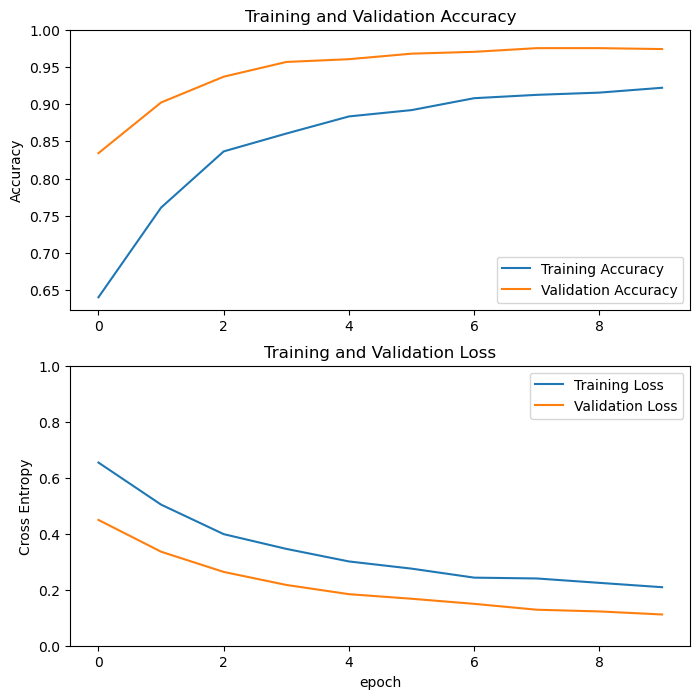

In [28]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Note: If you are wondering why the validation metrics are clearly better than the training metrics, the main factor is because layers like `tf.keras.layers.BatchNormalization` and `tf.keras.layers.Dropout` affect accuracy during training. They are turned off when calculating validation loss.

To a lesser extent, it is also because training metrics report the average for an epoch, while validation metrics are evaluated after the epoch, so validation metrics see a model that has trained slightly longer.

## Fine tuning
In the feature extraction experiment, you were only training a few layers on top of an MobileNetV2 base model. The weights of the pre-trained network were **not** updated during training.

One way to increase performance even further is to train (or "fine-tune") the weights of the top layers of the pre-trained model alongside the training of the classifier you added. The training process will force the weights to be tuned from generic feature maps to features associated specifically with the dataset.

Note: This should only be attempted after you have trained the top-level classifier with the pre-trained model set to non-trainable. If you add a randomly initialized classifier on top of a pre-trained model and attempt to train all layers jointly, the magnitude of the gradient updates will be too large (due to the random weights from the classifier) and your pre-trained model will forget what it has learned.

Also, you should try to fine-tune a small number of top layers rather than the whole MobileNet model. In most convolutional networks, the higher up a layer is, the more specialized it is. The first few layers learn very simple and generic features that generalize to almost all types of images. As you go higher up, the features are increasingly more specific to the dataset on which the model was trained. The goal of fine-tuning is to adapt these specialized features to work with the new dataset, rather than overwrite the generic learning.

### Un-freeze the top layers of the model


All you need to do is unfreeze the `base_model` and set the bottom layers to be un-trainable. Then, you should recompile the model (necessary for these changes to take effect), and resume training.

In [29]:
base_model.trainable = True

In [30]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


### Compile the model

As you are training a much larger model and want to readapt the pretrained weights, it is important to use a lower learning rate at this stage. Otherwise, your model could overfit very quickly.

In [31]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5, name='accuracy')])

In [32]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,862,721 (7.11 MB)

 Non-trainable params: 396,544 (1.51 MB)

In [33]:
len(model.trainable_variables)

56

### Continue training the model

If you trained to convergence earlier, this step will improve your accuracy by a few percentage points.

In [34]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=len(history.epoch),
                         validation_data=validation_dataset)

Epoch 11/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 56s 565ms/step - accuracy: 0.7952 - loss: 0.4216 - val_accuracy: 0.9839 - val_loss: 0.0729
Epoch 12/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 33s 527ms/step - accuracy: 0.8545 - loss: 0.3113 - val_accuracy: 0.9814 - val_loss: 0.0662
Epoch 13/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 32s 506ms/step - accuracy: 0.9014 - loss: 0.2285 - val_accuracy: 0.9913 - val_loss: 0.0487
Epoch 14/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 32s 505ms/step - accuracy: 0.9259 - loss: 0.1904 - val_accuracy: 0.9864 - val_loss: 0.0449
Epoch 15/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 32s 513ms/step - accuracy: 0.9367 - loss: 0.1645 - val_accuracy: 0.9876 - val_loss: 0.0413
Epoch 16/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 33s 519ms/step - accuracy: 0.9428 - loss: 0.1492 - val_accuracy: 0.9851 - val_loss: 0.0437
Epoch 17/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 34s 536ms/step - accuracy: 0.9528 - loss: 0.1311 - val_accuracy: 0.9864 - val_loss: 0.0417
Epoch 18/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 31s 499ms/step - accuracy: 0.9506 - loss: 0.1302 - 

 8/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.8134 - loss: 0.4268

 9/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.8095 - loss: 0.4307

10/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.8073 - loss: 0.4333

11/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.8057 - loss: 0.4348

12/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.8032 - loss: 0.4377

13/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.8006 - loss: 0.4403

15/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.7969 - loss: 0.4434

16/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.7955 - loss: 0.4446

18/63 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.7941 - loss: 0.4455

19/63 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.7937 - loss: 0.4458

20/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.7936 - loss: 0.4460

21/63 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.7936 - loss: 0.4461

22/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.7935 - loss: 0.4460

24/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.7939 - loss: 0.4451

25/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.7944 - loss: 0.4443

26/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.7948 - loss: 0.4434

28/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.7959 - loss: 0.4413

29/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.7965 - loss: 0.4400

30/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.7971 - loss: 0.4389

31/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.7977 - loss: 0.4377

32/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.7983 - loss: 0.4366

33/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.7987 - loss: 0.4356

34/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.7990 - loss: 0.4347

35/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.7994 - loss: 0.4338

36/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.7997 - loss: 0.4329

37/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.8001 - loss: 0.4319

38/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.8005 - loss: 0.4310

39/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.8009 - loss: 0.4299

40/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.8014 - loss: 0.4289

41/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.8018 - loss: 0.4280

42/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.8023 - loss: 0.4270

44/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.8031 - loss: 0.4251

45/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.8036 - loss: 0.4240

46/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.8040 - loss: 0.4230

47/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.8045 - loss: 0.4220

48/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.8049 - loss: 0.4211

49/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.8053 - loss: 0.4201

50/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.8056 - loss: 0.4192

52/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.8064 - loss: 0.4173

53/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.8068 - loss: 0.4164

54/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.8071 - loss: 0.4155

55/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.8075 - loss: 0.4146

56/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.8079 - loss: 0.4138

58/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.8086 - loss: 0.4121

60/63 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.8092 - loss: 0.4105

62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.8099 - loss: 0.4089

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.8102 - loss: 0.4081

W0000 00:00:1721365843.020209   77756 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1721365843.021380   77756 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1721365843.022427   77756 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1721365843.023447   77756 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1721365843.024361   77756 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1721365843.025311   77756 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1721365843.026339   77756 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1721365843.027376   77756 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1721365843.028338   77756 gp

63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 82ms/step - accuracy: 0.8106 - loss: 0.4074 - val_accuracy: 0.9752 - val_loss: 0.0909


Epoch 12/20


 1/63 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - accuracy: 0.9375 - loss: 0.2551

 2/63 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.9141 - loss: 0.2764

 3/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.9045 - loss: 0.2876

 4/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.9010 - loss: 0.2961

 6/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.8983 - loss: 0.2957

 7/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.8969 - loss: 0.2947

 8/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.8956 - loss: 0.2938

 9/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.8948 - loss: 0.2925

10/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.8944 - loss: 0.2919

12/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.8930 - loss: 0.2910

13/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.8920 - loss: 0.2913

14/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.8917 - loss: 0.2906

15/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.8916 - loss: 0.2898

16/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.8910 - loss: 0.2895

18/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.8902 - loss: 0.2882

19/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.8899 - loss: 0.2877

20/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.8896 - loss: 0.2871

21/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.8894 - loss: 0.2865

22/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.8891 - loss: 0.2860

23/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.8890 - loss: 0.2854

24/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.8889 - loss: 0.2847

25/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.8887 - loss: 0.2842

26/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.8886 - loss: 0.2838

27/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.8885 - loss: 0.2835

28/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.8882 - loss: 0.2834

30/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.8878 - loss: 0.2829

31/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.8877 - loss: 0.2825

32/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.8877 - loss: 0.2821

34/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.8875 - loss: 0.2815

35/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.8875 - loss: 0.2812

36/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.8875 - loss: 0.2808

37/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.8875 - loss: 0.2805

38/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.8875 - loss: 0.2801

39/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.8875 - loss: 0.2798

40/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.8875 - loss: 0.2794

41/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.8875 - loss: 0.2790

42/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.8875 - loss: 0.2786

43/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.8875 - loss: 0.2782

44/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.8876 - loss: 0.2777

45/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.8877 - loss: 0.2773

46/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.8878 - loss: 0.2769

47/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.8878 - loss: 0.2766

48/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.8879 - loss: 0.2763

50/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.8880 - loss: 0.2757

52/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.8882 - loss: 0.2751

54/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.8883 - loss: 0.2745

55/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.8883 - loss: 0.2742

56/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.8884 - loss: 0.2739

58/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.8885 - loss: 0.2733

60/63 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.8886 - loss: 0.2727

61/63 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.8886 - loss: 0.2724

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.8888 - loss: 0.2719

63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - accuracy: 0.8888 - loss: 0.2716 - val_accuracy: 0.9827 - val_loss: 0.0736


Epoch 13/20


 1/63 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - accuracy: 0.9688 - loss: 0.2143

 2/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.9531 - loss: 0.2168

 3/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.9479 - loss: 0.2136

 4/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.9414 - loss: 0.2184

 5/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9319 - loss: 0.2248

 6/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9250 - loss: 0.2307

 7/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9223 - loss: 0.2325

 8/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9213 - loss: 0.2332

 9/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9188 - loss: 0.2354

10/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9176 - loss: 0.2363

11/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9171 - loss: 0.2365

13/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9166 - loss: 0.2358

14/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9165 - loss: 0.2351

15/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9162 - loss: 0.2345

16/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9162 - loss: 0.2339

17/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9164 - loss: 0.2332

18/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9165 - loss: 0.2324

19/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9166 - loss: 0.2315

20/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9169 - loss: 0.2305

21/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9172 - loss: 0.2296

23/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9175 - loss: 0.2277

24/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9176 - loss: 0.2269

25/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9177 - loss: 0.2261

26/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9179 - loss: 0.2252

27/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9180 - loss: 0.2244

28/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9181 - loss: 0.2238

29/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9181 - loss: 0.2232

30/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9181 - loss: 0.2227

31/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9181 - loss: 0.2222

32/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9182 - loss: 0.2217

33/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9182 - loss: 0.2212

35/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9182 - loss: 0.2204

36/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9182 - loss: 0.2201

37/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9183 - loss: 0.2198

38/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9183 - loss: 0.2195

39/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9184 - loss: 0.2192

41/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9186 - loss: 0.2185

42/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9187 - loss: 0.2182

43/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9187 - loss: 0.2179

45/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9188 - loss: 0.2174

46/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9188 - loss: 0.2171

47/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9189 - loss: 0.2169

48/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9189 - loss: 0.2166

49/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9189 - loss: 0.2164

51/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9191 - loss: 0.2159

52/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9191 - loss: 0.2157

53/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9192 - loss: 0.2154

54/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9192 - loss: 0.2151

55/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9193 - loss: 0.2149

57/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9194 - loss: 0.2144

59/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9195 - loss: 0.2140

61/63 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9196 - loss: 0.2135

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9197 - loss: 0.2131

63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - accuracy: 0.9197 - loss: 0.2129 - val_accuracy: 0.9851 - val_loss: 0.0635


Epoch 14/20


 1/63 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - accuracy: 0.9375 - loss: 0.1705

 2/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.9375 - loss: 0.1685

 3/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.9444 - loss: 0.1627

 4/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.9466 - loss: 0.1586

 5/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9423 - loss: 0.1628

 6/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9389 - loss: 0.1664

 7/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9349 - loss: 0.1710

 9/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9297 - loss: 0.1769

10/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9286 - loss: 0.1779

11/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9276 - loss: 0.1787

13/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9266 - loss: 0.1796

14/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9260 - loss: 0.1807

15/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9253 - loss: 0.1817

16/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9248 - loss: 0.1825

17/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9244 - loss: 0.1829

18/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9241 - loss: 0.1832

19/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9239 - loss: 0.1834

20/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9238 - loss: 0.1835

21/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9235 - loss: 0.1838

23/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9229 - loss: 0.1843

24/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9228 - loss: 0.1843

25/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9227 - loss: 0.1843

27/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9225 - loss: 0.1841

29/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9226 - loss: 0.1838

30/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9226 - loss: 0.1837

31/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9226 - loss: 0.1835

32/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9226 - loss: 0.1834

33/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9226 - loss: 0.1832

34/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9226 - loss: 0.1832

35/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9225 - loss: 0.1832

36/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9225 - loss: 0.1831

37/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9225 - loss: 0.1830

39/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9224 - loss: 0.1830

40/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9223 - loss: 0.1830

41/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9223 - loss: 0.1830

43/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9222 - loss: 0.1831

44/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9221 - loss: 0.1831

45/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9221 - loss: 0.1831

47/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9220 - loss: 0.1831

49/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9219 - loss: 0.1832

50/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9219 - loss: 0.1832

51/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9219 - loss: 0.1831

53/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9220 - loss: 0.1830

54/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9220 - loss: 0.1830

55/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9221 - loss: 0.1829

56/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9221 - loss: 0.1829

57/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9221 - loss: 0.1829

59/63 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9222 - loss: 0.1829

61/63 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9222 - loss: 0.1829

62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9222 - loss: 0.1830

63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - accuracy: 0.9223 - loss: 0.1830 - val_accuracy: 0.9851 - val_loss: 0.0588


Epoch 15/20


 1/63 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - accuracy: 0.9688 - loss: 0.1100

 2/63 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.9375 - loss: 0.1442

 3/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.9340 - loss: 0.1456

 4/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.9349 - loss: 0.1441

 5/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9354 - loss: 0.1434

 6/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9358 - loss: 0.1434

 7/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9366 - loss: 0.1431

 8/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9372 - loss: 0.1445

10/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9383 - loss: 0.1469

11/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9385 - loss: 0.1482

12/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9391 - loss: 0.1487

13/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9393 - loss: 0.1491

14/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9390 - loss: 0.1501

16/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9386 - loss: 0.1522

17/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9382 - loss: 0.1532

18/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9381 - loss: 0.1538

19/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9379 - loss: 0.1542

20/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9378 - loss: 0.1546

22/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9376 - loss: 0.1554

23/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9376 - loss: 0.1557

24/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9377 - loss: 0.1559

25/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9376 - loss: 0.1561

26/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9377 - loss: 0.1561

28/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9380 - loss: 0.1559

29/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9381 - loss: 0.1559

30/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9382 - loss: 0.1559

32/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9384 - loss: 0.1559

33/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9386 - loss: 0.1559

34/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9388 - loss: 0.1559

36/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9391 - loss: 0.1558

37/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9393 - loss: 0.1558

38/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9393 - loss: 0.1559

39/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9395 - loss: 0.1559

40/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9395 - loss: 0.1560

42/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9397 - loss: 0.1560

43/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9397 - loss: 0.1561

44/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9398 - loss: 0.1561

46/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9400 - loss: 0.1561

47/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9400 - loss: 0.1561

48/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9401 - loss: 0.1561

49/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9402 - loss: 0.1561

50/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9403 - loss: 0.1561

52/63 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9405 - loss: 0.1560

53/63 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9406 - loss: 0.1559

55/63 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9408 - loss: 0.1558

56/63 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9409 - loss: 0.1557

57/63 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9410 - loss: 0.1557

59/63 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9411 - loss: 0.1555

61/63 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9413 - loss: 0.1553

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9414 - loss: 0.1553

63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - accuracy: 0.9414 - loss: 0.1553 - val_accuracy: 0.9851 - val_loss: 0.0573


Epoch 16/20


 1/63 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - accuracy: 0.9062 - loss: 0.2100

 2/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.9062 - loss: 0.2023

 3/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.8993 - loss: 0.2138

 4/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9010 - loss: 0.2126

 6/63 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9102 - loss: 0.1994

 8/63 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9150 - loss: 0.1907

 9/63 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9164 - loss: 0.1876

10/63 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9179 - loss: 0.1848

12/63 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9214 - loss: 0.1790

13/63 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9226 - loss: 0.1769

14/63 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9233 - loss: 0.1755

16/63 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9249 - loss: 0.1730

17/63 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9255 - loss: 0.1720

18/63 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9262 - loss: 0.1710

19/63 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9268 - loss: 0.1700

20/63 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9274 - loss: 0.1690

21/63 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9281 - loss: 0.1678

22/63 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9289 - loss: 0.1667

24/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9300 - loss: 0.1647

25/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9304 - loss: 0.1640

27/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9311 - loss: 0.1627

28/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9316 - loss: 0.1621

29/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9319 - loss: 0.1617

31/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9324 - loss: 0.1608

32/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9327 - loss: 0.1606

33/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9328 - loss: 0.1603

34/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9331 - loss: 0.1601

35/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9332 - loss: 0.1598

37/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9335 - loss: 0.1595

38/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9337 - loss: 0.1594

39/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9338 - loss: 0.1593

41/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9339 - loss: 0.1593

42/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9340 - loss: 0.1593

43/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9340 - loss: 0.1593

44/63 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9341 - loss: 0.1593

45/63 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9342 - loss: 0.1593

47/63 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9344 - loss: 0.1592

48/63 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9345 - loss: 0.1591

49/63 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9347 - loss: 0.1590

51/63 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9349 - loss: 0.1588

52/63 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9350 - loss: 0.1587

53/63 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9351 - loss: 0.1586

54/63 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9352 - loss: 0.1586

56/63 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9353 - loss: 0.1584

57/63 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9354 - loss: 0.1583

58/63 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9355 - loss: 0.1583

60/63 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9356 - loss: 0.1581

62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9358 - loss: 0.1580

63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - accuracy: 0.9359 - loss: 0.1579 - val_accuracy: 0.9876 - val_loss: 0.0497


Epoch 17/20


 1/63 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - accuracy: 0.8750 - loss: 0.1881

 2/63 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.9062 - loss: 0.1634

 3/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.9201 - loss: 0.1479

 5/63 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9355 - loss: 0.1305

 6/63 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9376 - loss: 0.1279

 7/63 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9401 - loss: 0.1257

 9/63 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9424 - loss: 0.1261

10/63 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9425 - loss: 0.1279

11/63 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9428 - loss: 0.1293

12/63 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9433 - loss: 0.1305

13/63 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9439 - loss: 0.1309

15/63 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9451 - loss: 0.1308

16/63 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9453 - loss: 0.1308

17/63 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9456 - loss: 0.1305

19/63 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9459 - loss: 0.1304

20/63 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9460 - loss: 0.1304

21/63 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9459 - loss: 0.1306

23/63 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9460 - loss: 0.1309

24/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9461 - loss: 0.1310

26/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9460 - loss: 0.1311

28/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9461 - loss: 0.1309

30/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9463 - loss: 0.1307

31/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9464 - loss: 0.1306

32/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9465 - loss: 0.1305

34/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9467 - loss: 0.1302

35/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9468 - loss: 0.1301

36/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9469 - loss: 0.1299

37/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9469 - loss: 0.1298

38/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9470 - loss: 0.1297

40/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9471 - loss: 0.1295

41/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9471 - loss: 0.1294

43/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9472 - loss: 0.1293

44/63 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9473 - loss: 0.1292

45/63 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9473 - loss: 0.1292

47/63 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9474 - loss: 0.1291

49/63 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9473 - loss: 0.1291

50/63 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9473 - loss: 0.1291

51/63 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9472 - loss: 0.1292

52/63 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9472 - loss: 0.1292

53/63 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9471 - loss: 0.1292

55/63 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9471 - loss: 0.1292

56/63 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9470 - loss: 0.1293

58/63 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9470 - loss: 0.1293

60/63 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9470 - loss: 0.1293

62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9470 - loss: 0.1292

63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - accuracy: 0.9471 - loss: 0.1291 - val_accuracy: 0.9814 - val_loss: 0.0536


Epoch 18/20


 1/63 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - accuracy: 1.0000 - loss: 0.0465

 3/63 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9844 - loss: 0.0728

 5/63 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9753 - loss: 0.0876

 7/63 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.9728 - loss: 0.0939

 8/63 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.9718 - loss: 0.0964

 9/63 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9707 - loss: 0.0985

11/63 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.9685 - loss: 0.1013

12/63 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9672 - loss: 0.1032

14/63 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9651 - loss: 0.1074

15/63 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9642 - loss: 0.1089

16/63 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9633 - loss: 0.1106

17/63 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9624 - loss: 0.1122

18/63 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9614 - loss: 0.1139

20/63 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9598 - loss: 0.1164

21/63 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9593 - loss: 0.1171

22/63 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9589 - loss: 0.1180

24/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9583 - loss: 0.1191

25/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9580 - loss: 0.1196

27/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9575 - loss: 0.1203

29/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9570 - loss: 0.1210

30/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9568 - loss: 0.1213

31/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9566 - loss: 0.1215

32/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9565 - loss: 0.1218

33/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9563 - loss: 0.1219

34/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9562 - loss: 0.1221

35/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9562 - loss: 0.1222

37/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9561 - loss: 0.1222

39/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9560 - loss: 0.1222

40/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9561 - loss: 0.1222

41/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9561 - loss: 0.1223

43/63 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9560 - loss: 0.1224

44/63 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9561 - loss: 0.1225

45/63 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9561 - loss: 0.1226

46/63 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9561 - loss: 0.1226

48/63 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9560 - loss: 0.1228

50/63 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9560 - loss: 0.1229

51/63 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9560 - loss: 0.1229

52/63 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9560 - loss: 0.1230

53/63 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9560 - loss: 0.1230

54/63 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9560 - loss: 0.1231

55/63 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9560 - loss: 0.1232

56/63 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9559 - loss: 0.1233

58/63 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9559 - loss: 0.1235

60/63 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9558 - loss: 0.1237

62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9558 - loss: 0.1238

63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - accuracy: 0.9557 - loss: 0.1239 - val_accuracy: 0.9827 - val_loss: 0.0517


Epoch 19/20


 1/63 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - accuracy: 1.0000 - loss: 0.0521

 2/63 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.9844 - loss: 0.0726

 4/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9785 - loss: 0.0882

 5/63 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9753 - loss: 0.0929

 6/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9742 - loss: 0.0947

 8/63 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9713 - loss: 0.0988

 9/63 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9703 - loss: 0.0997

10/63 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9692 - loss: 0.1012

12/63 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9680 - loss: 0.1034

13/63 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9673 - loss: 0.1048

15/63 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9650 - loss: 0.1085

17/63 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9633 - loss: 0.1114

18/63 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9624 - loss: 0.1128

19/63 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9614 - loss: 0.1141

21/63 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9602 - loss: 0.1159

23/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9595 - loss: 0.1167

24/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9593 - loss: 0.1169

26/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9589 - loss: 0.1173

28/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9584 - loss: 0.1182

30/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9581 - loss: 0.1188

31/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9579 - loss: 0.1190

32/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9579 - loss: 0.1191

34/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9579 - loss: 0.1191

35/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9579 - loss: 0.1191

37/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9578 - loss: 0.1191

39/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9578 - loss: 0.1192

41/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9577 - loss: 0.1193

42/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9577 - loss: 0.1193

43/63 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9577 - loss: 0.1193

45/63 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9578 - loss: 0.1192

46/63 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9578 - loss: 0.1191

48/63 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9579 - loss: 0.1190

49/63 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9579 - loss: 0.1190

50/63 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9579 - loss: 0.1191

52/63 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9579 - loss: 0.1191

53/63 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9579 - loss: 0.1191

54/63 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9579 - loss: 0.1191

56/63 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9579 - loss: 0.1192

57/63 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9579 - loss: 0.1192

58/63 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9579 - loss: 0.1193

60/63 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9578 - loss: 0.1194

61/63 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9578 - loss: 0.1195

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9577 - loss: 0.1196

63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - accuracy: 0.9577 - loss: 0.1197 - val_accuracy: 0.9839 - val_loss: 0.0502


Epoch 20/20


 1/63 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - accuracy: 0.9375 - loss: 0.1522

 2/63 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.9453 - loss: 0.1326

 4/63 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9590 - loss: 0.1118

 6/63 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9633 - loss: 0.1060

 8/63 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9642 - loss: 0.1048

 9/63 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9635 - loss: 0.1062

11/63 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9634 - loss: 0.1076

13/63 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.9636 - loss: 0.1083

15/63 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.9635 - loss: 0.1089

16/63 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.9634 - loss: 0.1092

18/63 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.9625 - loss: 0.1110

20/63 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.9616 - loss: 0.1123

22/63 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.9609 - loss: 0.1133

23/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9606 - loss: 0.1137

24/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9603 - loss: 0.1139

25/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9602 - loss: 0.1141

26/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9598 - loss: 0.1149

27/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9594 - loss: 0.1155

28/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9591 - loss: 0.1161

29/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9588 - loss: 0.1166

31/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9583 - loss: 0.1174

33/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9578 - loss: 0.1182

34/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9576 - loss: 0.1186

35/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9574 - loss: 0.1189

37/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9571 - loss: 0.1192

38/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9569 - loss: 0.1194

40/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9566 - loss: 0.1198

42/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9564 - loss: 0.1201

44/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9563 - loss: 0.1203

45/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9562 - loss: 0.1204

47/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9561 - loss: 0.1205

49/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9561 - loss: 0.1206

50/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9560 - loss: 0.1206

51/63 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9560 - loss: 0.1205

53/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9559 - loss: 0.1205

54/63 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9559 - loss: 0.1204

56/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9558 - loss: 0.1204

58/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9557 - loss: 0.1204

60/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9557 - loss: 0.1203

62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9556 - loss: 0.1203

63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - accuracy: 0.9556 - loss: 0.1202 - val_accuracy: 0.9851 - val_loss: 0.0473


Let's take a look at the learning curves of the training and validation accuracy/loss when fine-tuning the last few layers of the MobileNetV2 base model and training the classifier on top of it. The validation loss is much higher than the training loss, so you may get some overfitting.

You may also get some overfitting as the new training set is relatively small and similar to the original MobileNetV2 datasets.


After fine tuning the model nearly reaches 98% accuracy on the validation set.

In [35]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

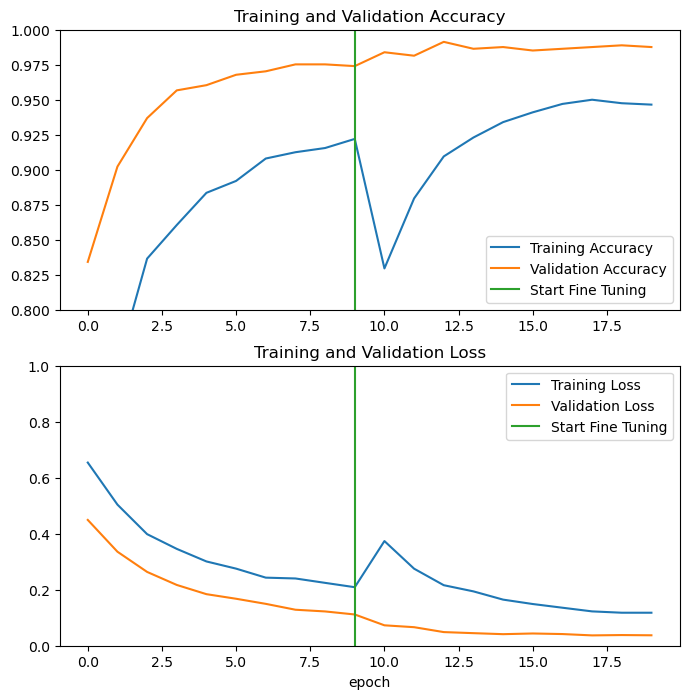

In [36]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Evaluation and prediction

Finally you can verify the performance of the model on new data using test set.

In [37]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 211ms/step - accuracy: 0.9906 - loss: 0.0367
Test accuracy : 0.9791666865348816


5/6 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9907 - loss: 0.0295

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9904 - loss: 0.0288


Test accuracy : 0.9895833134651184


And now you are all set to use this model to predict if your pet is a cat or dog.

Predictions:
 [0 1 1 1 1 0 0 0 1 0 1 0 0 0 1 0 1 1 0 1 1 1 1 1 1 0 1 1 1 0 1 1]
Labels:
 [0 1 1 1 1 0 0 0 1 0 1 0 0 0 1 0 1 1 0 1 1 1 1 1 1 0 1 1 1 0 1 1]


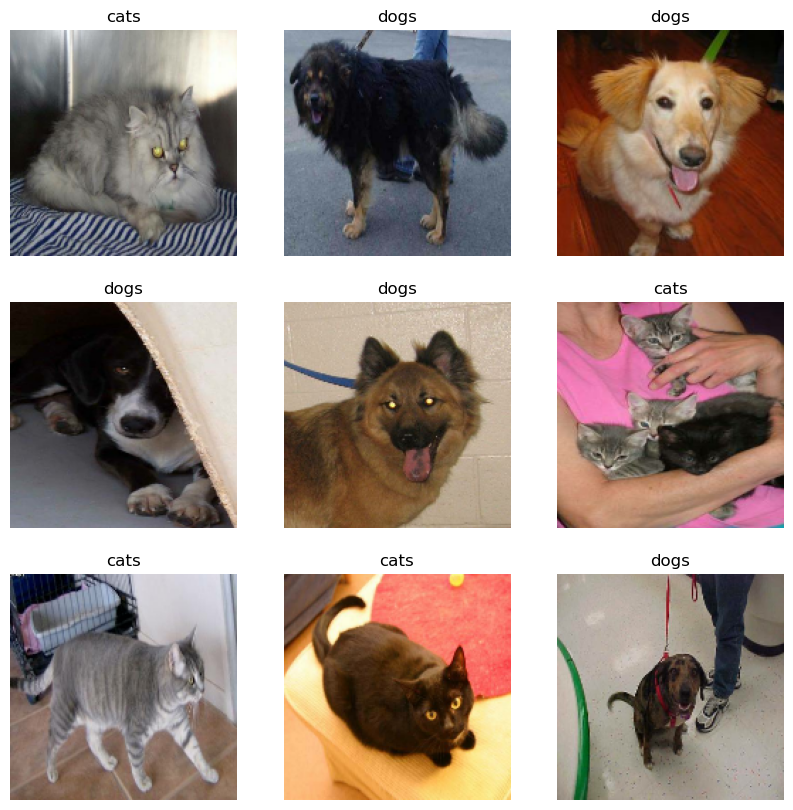

In [38]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

## Summary

* **Using a pre-trained model for feature extraction**:  When working with a small dataset, it is a common practice to take advantage of features learned by a model trained on a larger dataset in the same domain. This is done by instantiating the pre-trained model and adding a fully-connected classifier on top. The pre-trained model is "frozen" and only the weights of the classifier get updated during training.
In this case, the convolutional base extracted all the features associated with each image and you just trained a classifier that determines the image class given that set of extracted features.

* **Fine-tuning a pre-trained model**: To further improve performance, one might want to repurpose the top-level layers of the pre-trained models to the new dataset via fine-tuning.
In this case, you tuned your weights such that your model learned high-level features specific to the dataset. This technique is usually recommended when the training dataset is large and very similar to the original dataset that the pre-trained model was trained on.

To learn more, visit the [Transfer learning guide](https://www.tensorflow.org/guide/keras/transfer_learning).
